In [4]:
import numpy as np

import matplotlib.pyplot as plt

import time

from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.util import norm
from poliastro.constants import R_earth
from poliastro.core.elements import coe2rv
from poliastro.core.propagation import func_twobody 
from poliastro.twobody.thrust import change_a_inc
from poliastro.twobody.sampling import EpochsArray
from poliastro.twobody.propagation import CowellPropagator

from astropy import units as u
from astropy.time import Time, TimeDelta

from datetime import datetime
from sso_inc import inc_from_alt, raan_from_ltan,angle_between

from perturbations import perturbations_coesa_J2_low, perturbations_coesa_J2_high, coesa_J2
from osc2mean_dd import osc2mean



toc = time.time()

## Orbit
h = 350
start_date = datetime(2024,1,1,9,0,0)
ltan = 22.5

a = (R_earth.value/1000 + h) << u.km
ecc = 1e-6 << u.one
inc = inc_from_alt(h,ecc)[0] << u.deg   
raan = raan_from_ltan(Time(val=datetime.timestamp(start_date), format='unix'),ltan) << u.deg
argp = 1e-6 << u.deg
nu = 1e-6 << u.deg

epoch = Time(val=start_date.isoformat(), format='isot')

delta_a = [0.75,1.5]
delta_nu = [0,0]

reference_orbit = Orbit.from_classical(
    Earth,
    a,
    ecc,
    inc,
    raan,
    argp,
    nu,
    epoch
)


time_step = 3600<<u.s
pred_days = 10
start_date_prop = epoch

refsmalist = []
refsmalist_mean = [[],[]]
trailsmalist = []
trailsmalist_mean = [[],[]]

ref_vel = []
trail_vel = []
elapsedsecs = [[],[]]
secs = 0
rmag_ref = []
rmag_trail = []
vmag_ref = []
vmag_trail = []
angle_list = [[],[]]
ang_vel_list = []
hd_window = []
hd_duration = []

assignment_list = [120,240]
trail_sats = 2
trail_orbits = []
ref_orbits = []
mans = 1

## Foster Algorithm (Commissioning Phase)
for sat in range(trail_sats):
    trailing_orbit = Orbit.from_classical(
        Earth,
        (a.value+delta_a[sat])<<u.km,
        ecc,
        inc,
        raan,
        argp,
        (nu.value+delta_nu[sat])<<u.deg,
        epoch
    )

    reference_orbit = Orbit.from_classical(
        Earth,
        a,
        ecc,
        inc,
        raan,
        argp,
        nu,
        epoch
    )

    assignment = assignment_list[sat]

    ref_mean = osc2mean(a.value, ecc.value, inc.value, raan.value, argp.value, nu.value)
    ref_mean_orbit = Orbit.from_classical(Earth, ref_mean[0]<<u.km, ref_mean[1]<<u.one, ref_mean[2]<<u.deg, ref_mean[3]<<u.deg, ref_mean[4]<<u.deg, nu, epoch)
    trail_mean = osc2mean(a.value+delta_a[sat], ecc.value, inc.value, raan.value, argp.value, nu.value+delta_nu[sat])
    trail_mean_orbit = Orbit.from_classical(Earth, trail_mean[0]<<u.km, trail_mean[1]<<u.one, trail_mean[2]<<u.deg, trail_mean[3]<<u.deg, trail_mean[4]<<u.deg, nu+(delta_nu[sat]<<u.deg), epoch)

    for i in range(mans):
    
        theta_err = (assignment - angle_between(trailing_orbit.r.value, reference_orbit.r.value))%360

        tra_orb_pred = trailing_orbit.propagate(pred_days<<u.day, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_high))
        tra_pred_mean = osc2mean(tra_orb_pred.a.value, tra_orb_pred.ecc.value, tra_orb_pred.inc.to_value(u.deg), tra_orb_pred.raan.to_value(u.deg), tra_orb_pred.argp.to_value(u.deg), tra_orb_pred.nu.to_value(u.deg))
        tra_orb_pred_mean = Orbit.from_classical(Earth, tra_pred_mean[0]<<u.km, tra_pred_mean[1]<<u.one, tra_pred_mean[2]<<u.deg, tra_pred_mean[3]<<u.deg, tra_pred_mean[4]<<u.deg, tra_orb_pred.nu.to(u.deg), tra_orb_pred.epoch)

        theta_dot_dot = (tra_orb_pred_mean.n.to(u.deg/u.s) - trail_mean_orbit.n.to(u.deg/u.s)) / ((pred_days*60*60*24)<<u.s)
        t_hd = (ref_mean_orbit.n.to(u.deg/u.s) - trail_mean_orbit.n.to(u.deg/u.s)) / theta_dot_dot
        theta_hd = 0.5 * theta_dot_dot * t_hd**2
        t_wait = (theta_err - theta_hd.value) / (ref_mean_orbit.n.to_value(u.deg/u.s) - trail_mean_orbit.n.to_value(u.deg/u.s))       

        num_wait = int(t_wait / time_step.value)
        tofs_wait = TimeDelta(np.linspace(0, t_wait<<u.s, num=num_wait))
        reference_ephem = reference_orbit.to_ephem(EpochsArray(start_date_prop + tofs_wait, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))
        trailing_ephem = trailing_orbit.to_ephem(EpochsArray(start_date_prop + tofs_wait, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))

        for t in range(len(tofs_wait)):

            secs += time_step.value

            ref_from_ephem = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t])
            trail_from_ephem = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t])

            refsmalist.append(ref_from_ephem.a.value)
            trailsmalist.append(trail_from_ephem.a.value)

            ref_mean = osc2mean(
                ref_from_ephem.a.value,
                ref_from_ephem.ecc.value,
                ref_from_ephem.inc.to_value(u.deg),
                ref_from_ephem.raan.to_value(u.deg),
                ref_from_ephem.argp.to_value(u.deg),
                ref_from_ephem.nu.to_value(u.deg)

            )
            trail_mean = osc2mean(
                trail_from_ephem.a.value,
                trail_from_ephem.ecc.value,
                trail_from_ephem.inc.to_value(u.deg),
                trail_from_ephem.raan.to_value(u.deg),
                trail_from_ephem.argp.to_value(u.deg),
                trail_from_ephem.nu.to_value(u.deg)
            )

            refsmalist_mean[sat].append(ref_mean[0])
            trailsmalist_mean[sat].append(trail_mean[0])

            angle_list[sat].append(angle_between(trail_from_ephem.r.value, ref_from_ephem.r.value))


            elapsedsecs[sat].append(secs)

        reference_orbit = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[-1])
        trailing_orbit = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[-1])

        num_hd = int(t_hd.value / time_step.value)
        tofs_hd = TimeDelta(np.linspace(0, t_hd, num=num_hd))

        reference_ephem = reference_orbit.to_ephem(EpochsArray(reference_ephem.epochs[-1] + tofs_hd, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))
        trailing_ephem = trailing_orbit.to_ephem(EpochsArray(trailing_ephem.epochs[-1] + tofs_hd, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_high)))

        for t in range(len(tofs_hd)):
            
            secs += time_step.value

            ref_from_ephem = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t])
            trail_from_ephem = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t])

            refsmalist.append(ref_from_ephem.a.value)
            trailsmalist.append(trail_from_ephem.a.value)

            ref_mean = osc2mean(
                ref_from_ephem.a.value,
                ref_from_ephem.ecc.value,
                ref_from_ephem.inc.to_value(u.deg),
                ref_from_ephem.raan.to_value(u.deg),
                ref_from_ephem.argp.to_value(u.deg),
                ref_from_ephem.nu.to_value(u.deg)

            )
            trail_mean = osc2mean(
                trail_from_ephem.a.value,
                trail_from_ephem.ecc.value,
                trail_from_ephem.inc.to_value(u.deg),
                trail_from_ephem.raan.to_value(u.deg),
                trail_from_ephem.argp.to_value(u.deg),
                trail_from_ephem.nu.to_value(u.deg)
            )

            refsmalist_mean[sat].append(ref_mean[0])
            trailsmalist_mean[sat].append(trail_mean[0])

            angle_list[sat].append(angle_between(trail_from_ephem.r.value, ref_from_ephem.r.value))

            elapsedsecs[sat].append(secs)

        reference_orbit = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[-1])
        trailing_orbit = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[-1])

        ref_mean = osc2mean(
            reference_orbit.a.value, 
            reference_orbit.ecc.value, 
            reference_orbit.inc.to_value(u.deg), 
            reference_orbit.raan.to_value(u.deg), 
            reference_orbit.argp.to_value(u.deg), 
            reference_orbit.nu.to_value(u.deg)
            )
        ref_mean_orbit = Orbit.from_classical(
                                            Earth, 
                                            ref_mean[0]<<u.km, 
                                            ref_mean[1]<<u.one, 
                                            ref_mean[2]<<u.deg, 
                                            ref_mean[3]<<u.deg, 
                                            ref_mean[4]<<u.deg, 
                                            reference_orbit.nu.to(u.deg), 
                                            reference_orbit.epoch
                                            )

        trail_mean = osc2mean(
            trailing_orbit.a.value, 
            trailing_orbit.ecc.value, 
            trailing_orbit.inc.to_value(u.deg), 
            trailing_orbit.raan.to_value(u.deg), 
            trailing_orbit.argp.to_value(u.deg), 
            trailing_orbit.nu.to_value(u.deg)
            )
        trail_mean_orbit = Orbit.from_classical(
                                                Earth, 
                                                trail_mean[0]<<u.km, 
                                                trail_mean[1]<<u.one, 
                                                trail_mean[2]<<u.deg, 
                                                trail_mean[3]<<u.deg, 
                                                trail_mean[4]<<u.deg, 
                                                trailing_orbit.nu.to(u.deg), 
                                                trailing_orbit.epoch
                                                )

        start_date_prop = reference_orbit.epoch

    trail_orbits.append(trailing_orbit)
    ref_orbits.append(reference_orbit)




elapsed_days = []
for sec in range(len(elapsedsecs[-1])):
    elapsed_days.append(elapsedsecs[-1][sec]/(60*60*24))

trail_mean_altitudes = [[],[]]
ref_mean_altitudes = [[],[]]
for sat in range(trail_sats):

    for sma in range(len(trailsmalist_mean[sat])):
        trail_mean_altitudes[sat].append(trailsmalist_mean[sat][sma] - Earth.R_mean.to_value(u.km))

    for sma in range(len(refsmalist_mean[sat])):
        ref_mean_altitudes[sat].append(refsmalist_mean[sat][sma] - Earth.R_mean.to_value(u.km))


fig, ax = plt.subplots(1, 2, figsize=(22,9), squeeze=False) 

ax[0,0].plot(elapsed_days,angle_list[0])
ax[0,0].plot(elapsed_days,angle_list[1])
ax[0,0].axhline(assignment,linestyle='--',color='red',label = f'Assigned Slot at {assignment}deg')
ax[0,0].legend(loc = 'upper left')
ax[0,0].set_title('Angle Between Satellites')
ax[0,0].set_xlabel('Days')
ax[0,0].set_ylabel('Degrees')

ax[0,1].plot(elapsed_days,trail_mean_altitudes[0],label='Trail')
ax[0,1].plot(elapsed_days,trail_mean_altitudes[1],label='Trail')
ax[0,1].plot(elapsed_days,ref_mean_altitudes[-1],label='Ref')
ax[0,1].set_title('Ref vs Trail Mean Altitudes')
ax[0,1].set_xlabel('Days')
ax[0,1].set_ylabel('Km')

tic = time.time()
print(f'Timestep {time_step:.4f}s')
print(f'Run time {tic-toc:.2f}s/{(tic-toc)/60:.2f}m')
plt.show()










TypeError: unsupported operand type(s) for /: 'list' and 'int'

Timestep 3600.0000 ss
Run time 731.02s/12.18m


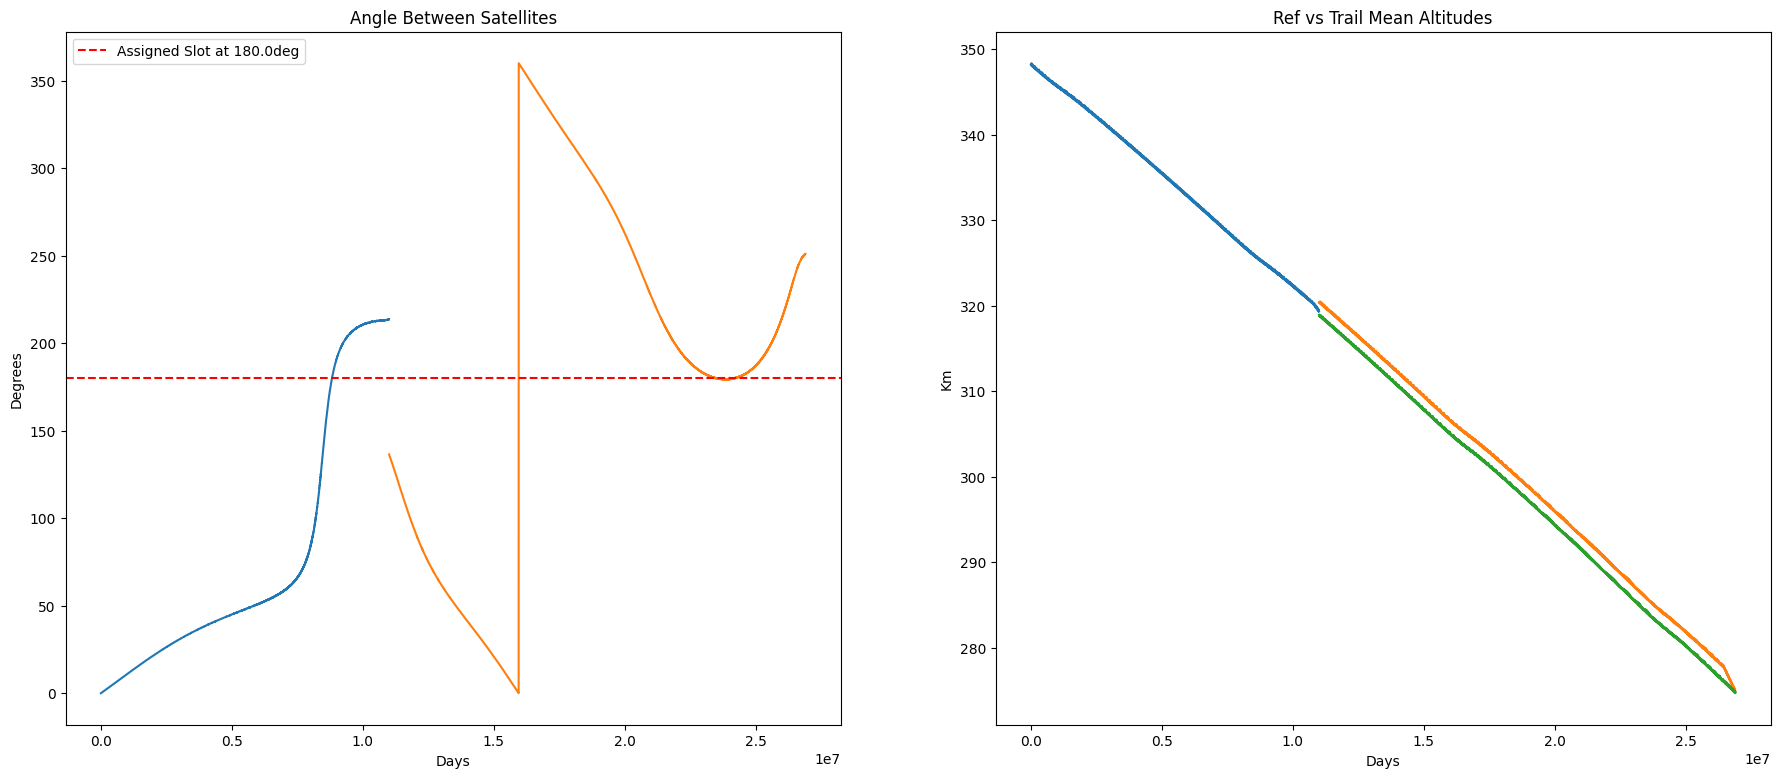

In [9]:
elapsed_days = []
for sec in range(len(elapsedsecs[-1])):
    elapsed_days.append(elapsedsecs[-1][sec]/(60*60*24))

trail_mean_altitudes = [[],[]]
ref_mean_altitudes = [[],[]]
for sat in range(trail_sats):

    for sma in range(len(trailsmalist_mean[sat])):
        trail_mean_altitudes[sat].append(trailsmalist_mean[sat][sma] - Earth.R_mean.to_value(u.km))

    for sma in range(len(refsmalist_mean[sat])):
        ref_mean_altitudes[sat].append(refsmalist_mean[sat][sma] - Earth.R_mean.to_value(u.km))


fig, ax = plt.subplots(1, 2, figsize=(22,9), squeeze=False) 

ax[0,0].plot(elapsedsecs[0],angle_list[0])
ax[0,0].plot(elapsedsecs[1],angle_list[1])
ax[0,0].axhline(assignment,linestyle='--',color='red',label = f'Assigned Slot at {assignment}deg')
ax[0,0].legend(loc = 'upper left')
ax[0,0].set_title('Angle Between Satellites')
ax[0,0].set_xlabel('Days')
ax[0,0].set_ylabel('Degrees')

ax[0,1].plot(elapsedsecs[0],trail_mean_altitudes[0],label='Trail')
ax[0,1].plot(elapsedsecs[1],trail_mean_altitudes[1],label='Trail')
ax[0,1].plot(elapsedsecs[1],ref_mean_altitudes[-1],label='Ref')
ax[0,1].set_title('Ref vs Trail Mean Altitudes')
ax[0,1].set_xlabel('Days')
ax[0,1].set_ylabel('Km')

tic = time.time()
print(f'Timestep {time_step:.4f}s')
print(f'Run time {tic-toc:.2f}s/{(tic-toc)/60:.2f}m')
plt.show()

